# ANALYTIC SPECTRAL DENSITIES
## No Smearing
We have, for non-subtracted spectral densities, that: 
$$C(t) = C_0 e^{-m_0 t} + C_1 e^{-m_1 t} = \int_0^{+\infty}d\omega\,\rho(\omega)e^{-\omega t} \qquad\rightarrow\qquad \rho(\omega) = C_0 \delta(\omega - m_0) + C_1\delta(\omega - m_1)$$

For the vector current, we have the subtracted:
$$C(t) = \int_0^{+\infty}d\omega\, \rho(\omega)\omega^2 e^{-\omega t} \qquad\rightarrow\qquad \rho(\omega)\omega^2 = C_0 \delta(\omega - m_0) + C_1\delta(\omega - m_1)\qquad\rightarrow\qquad \rho(\omega) = \frac{C_0}{m_0^2}\delta(\omega - m_0) + \frac{C_1}{m_1^2}\delta(\omega - m_1)$$

In the case where $\sigma = 0$, we can't consider $\alpha = 0$. We have that:
$$\rho_\alpha (\omega) = \int_0^{+\infty}d\omega'\,\delta_\alpha(\omega, \omega')\rho(\omega') = \frac{C_0}{m_0^2}\delta_\alpha(\omega, m_0) + \frac{C_1}{m_1^2}\delta_\alpha(\omega, m_1).$$
The propagation of the errors is given by:
$$\begin{align}J &= \biggl(\frac{\partial\rho_\alpha}{\partial C_0}, \frac{\partial\rho_\alpha}{\partial m_0}, \frac{\partial\rho_\alpha}{\partial C_1}, \frac{\partial\rho_\alpha}{\partial m_1}\biggr) \\
\frac{\partial\rho}{\partial C_0} &= \frac{1}{m_0^2} \delta_\alpha(\omega, m_0) \\
\frac{\partial\rho}{\partial m_0} &= C_0\biggl(\frac{1}{m_0^2}\frac{\partial}{\partial m_0}\delta_\alpha(\omega, m_0) - \frac{2}{m_0^3}\delta_\alpha(\omega, m_0)\biggr)\\
\frac{\partial\rho}{\partial C_1} &= \frac{1}{m_1^2} \delta_\alpha(\omega, m_1) \\
\frac{\partial\rho}{\partial m_1} &= C_1\biggl(\frac{1}{m_1^2}\frac{\partial}{\partial m_1}\delta_\alpha(\omega, m_1) - \frac{2}{m_1^3}\delta_\alpha(\omega, m_1)\biggr)
\end{align}$$
with
$$\frac{\partial}{\partial m}\delta_\alpha(\omega, m) = \int_{-\infty}^{+\infty} ds\,\biggl(\frac{-1/2 + is}{m}\biggr)\frac{u_s^*(\omega)|\lambda_s|^2u_s(m)}{|\lambda_s|^2 + \alpha}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import gamma
import mpmath
from tqdm import tqdm

In [2]:
data = open("fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 10:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

In [3]:
alpha = [1e-6, 1e-9, 1e-12]

In [4]:
def u_s(s, w):
    return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))

def H_a(s, a):
    return np.pi/(np.pi + a*np.cosh(np.pi * s))

def delta(w1, w2, a):
    f = lambda x: (2.0 * u_s(x, w1).conjugate() * H_a(x, a) * u_s(x, w2)).real
    return quad(f, 0.0, +np.inf)[0]

def rho_alpha(w, par, a):
    return par[0] * delta(w, par[1], a) / par[1]**2.0 + par[2] * delta(w, par[3], a) / par[3]**2.0

def r_a_d_C0(w, par, a):
    return delta(w, par[1], a)/(par[1]**2.0)

def r_a_d_C1(w, par, a):
    return delta(w, par[3], a)/(par[3]**2.0)

def delta_d_m(w, m, a):
    f = lambda x: ((-1.0 + x *2.0j) * u_s(x, w).conjugate() * H_a(x, a) * u_s(x, m) / m).real
    return quad(f, 0.0, +np.inf)[0]

def r_a_d_m0(w, par, a):
    return par[0] * (-2.0/(par[1]**3.0) * delta(w, par[1], a) + delta_d_m(w, par[1], a) / par[1]**2.0)

def r_a_d_m1(w, par, a):
    return par[2] * (-2.0/(par[3]**3.0) * delta(w, par[3], a) + delta_d_m(w, par[3], a) / par[3]**2.0)

def jac_r_a(w, par, a):
    return np.array([r_a_d_C0(w, par, a), r_a_d_m0(w, par, a), r_a_d_C1(w, par, a), r_a_d_m1(w, par, a)])

def err_r_a(w, par, a, cov):
    return np.sqrt(jac_r_a(w, par, a).T @ cov @ jac_r_a(w, par, a))

/tmp/ipykernel_595/4114421329.py:5: RuntimeWarning: overflow encountered in cosh
  return np.pi/(np.pi + a*np.cosh(np.pi * s))


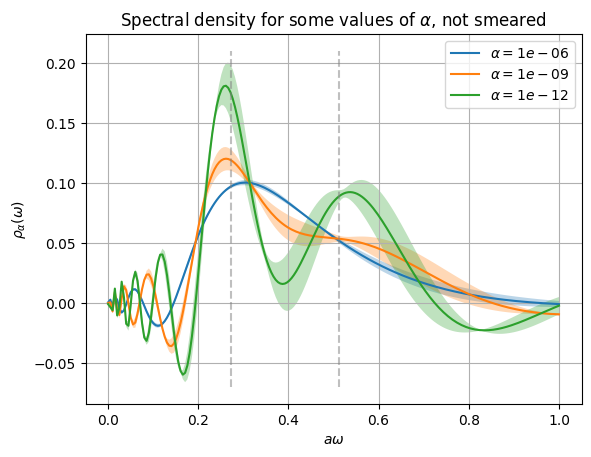

In [5]:
x = np.linspace(0.0001, 1, 200)
for a in alpha:
    y = []
    y_err = []
    for i in x:
        y.append(rho_alpha(i, par, a))
        y_err.append(err_r_a(i, par, a, cov))
    plt.plot(x, y, label=r"$\alpha = {}$".format(a))
    plt.fill_between(x, np.array(y)+np.array(y_err), np.array(y)-np.array(y_err), alpha = 0.3)

m1, m2 = np.zeros(1000), np.zeros(1000)
for i in range(len(m1)):
    m1[i] = par[1]
    m2[i] = par[3]
vert = np.linspace(-0.070, 0.210, 1000)
plt.plot(m1, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
plt.plot(m2, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
plt.legend()
plt.xlabel(r"$a\omega$")
plt.ylabel(r"$\rho_\alpha(\omega)$")
plt.grid()
plt.title(r"Spectral density for some values of $\alpha$, not smeared")
plt.savefig("Not_smeared_spectral_densities.png")

## With Smearing
If we consider a smearing with a gaussian distribution, $N_{m_1, \sigma}(\omega)$, we get, if $\alpha = 0$:
$$\rho_\sigma(\omega) = \frac{C_0}{m_0^2}N_{m_0, \sigma}(\omega) + \frac{C_1}{m_1^2}N_{m_1, \sigma}(\omega)$$

To propagate the errors, we need to compute the jacobian. We get:
$$\begin{align}J &= \biggl(\frac{\partial\rho}{\partial C_0}, \frac{\partial\rho}{\partial m_0}, \frac{\partial\rho}{\partial C_1}, \frac{\partial\rho}{\partial m_1}\biggr) \\
\frac{\partial\rho}{\partial C_0} &= \frac{1}{m_0^2} N_{m_0, \sigma}(\omega) \\
\frac{\partial\rho}{\partial m_0} &= -C_0\Bigl(\frac{2}{m_0^3} +\frac{(\omega - m_0)}{\sigma^2m_0^2}\Bigr)N_{m_0, \sigma}(\omega) \\
\frac{\partial\rho}{\partial C_1} &= \frac{1}{m_1^2} N_{m_1, \sigma}(\omega) \\
\frac{\partial\rho}{\partial m_1} &= -C_1\Bigl(\frac{2}{m_1^3} +\frac{(\omega - m_1)}{\sigma^2m_1^2}\Bigr)N_{m_1 \sigma}(\omega)
\end{align}$$
and the error on $\rho$ is $J^T C J$.

If $\alpha \neq 0$ instead, we have:
$$\rho_{\sigma, \alpha} (\omega) = \int_0^{+\infty}d\omega'd\omega''\,\rho(\omega')\delta_\alpha(\omega', \omega'')N_{\omega, \sigma}(\omega'') = \frac{C_0}{m_0^2}K_{\sigma, \alpha}(m_0, \omega) + \frac{C_1}{m_1^2}K_{\sigma, \alpha}(m_0, \omega),$$
with
$$K_{\sigma, \alpha}(\omega, \omega') = \int_0^{+\infty}d\omega'' \delta_\alpha(\omega,\omega'')N_{\omega', \sigma}(\omega'') = \int ds\frac{u_s^*(\omega)|\lambda_s|^2}{|\lambda_s|^2 + \alpha}\biggl(\int_0^{+\infty}d\omega''u_s(\omega'')N_{\omega', \sigma}(\omega'')\biggr) $$
The propagation of the errors is given by:
$$\begin{align}J &= \biggl(\frac{\partial\rho_{\sigma, \alpha}}{\partial C_0}, \frac{\partial\rho_{\sigma, \alpha}}{\partial m_0}, \frac{\partial\rho_{\sigma, \alpha}}{\partial C_1}, \frac{\partial\rho_{\sigma, \alpha}}{\partial m_1}\biggr) \\
\frac{\partial\rho}{\partial C_0} &= \frac{1}{m_0^2} K_{\sigma, \alpha}(m_0, \omega) \\
\frac{\partial\rho}{\partial m_0} &= C_0\biggl(\frac{1}{m_0^2}\frac{\partial}{\partial m_0}K_{\sigma, \alpha}(m_0, \omega) - \frac{2}{m_0^3}K_{\sigma, \alpha}(m_0, \omega)\biggr)\\
\frac{\partial\rho}{\partial C_1} &= \frac{1}{m_1^2} K_{\sigma, \alpha}(m_1, \omega) \\
\frac{\partial\rho}{\partial m_1} &= C_1\biggl(\frac{1}{m_1^2}\frac{\partial}{\partial m_1}K_{\sigma, \alpha}(m_1, \omega) - \frac{2}{m_1^3}K_{\sigma, \alpha}(m_1, \omega)\biggr)
\end{align}$$
with
$$\frac{\partial}{\partial m}K_{\sigma, \alpha}(m, \omega) = \int ds\biggl(\frac{-1/2-is}{m}\biggr)\frac{u_s^*(m)|\lambda_s|^2}{|\lambda_s|^2 + \alpha}\biggl(\int_0^{+\infty}d\omega''u_s(\omega'')N_{\omega, \sigma}(\omega'')\biggr)$$

In [5]:
alpha_s = [0, 1e-6, 1e-9, 1e-12]
width = [135.0/2.0, 135, 270, 540, 810]
scan = 200

In [6]:
#MEAN VALUE AND ERROR WITH ALPHA = 0
def rho(w, par, sigma):
    k = lambda x: norm(w, sigma).pdf(x)
    return par[0]/(par[1]**2.0)*k(par[1]) + par[2]/(par[3]**2.0)*k(par[3])

def der_C0(omega, par, sigma):
    return norm(par[1], sigma).pdf(omega) * 1/(par[1]**2.0)

def der_m0(omega, par, sigma):
    return par[0] * (-2.0 / (par[1]**3.0) + (omega - par[1])/(sigma**2.0 * par[1]**2.0)) * norm(omega, sigma).pdf(par[1])

def der_C1(omega, par, sigma):
    return norm(par[3], sigma).pdf(omega)/(par[3]**2.0)

def der_m1(omega, par, sigma):
    return par[2] * (-2.0 / (par[3]**3.0) + (omega - par[3])/(sigma**2.0 * par[3]**2.0)) * norm(omega, sigma).pdf(par[3])

def jacobian(omega, par, sigma):
    return np.array([der_C0(omega, par, sigma), der_m0(omega, par, sigma), der_C1(omega, par, sigma), der_m1(omega, par, sigma)])

def err_rho(omega, par, sigma, cov):
    return np.sqrt(jacobian(omega, par, sigma).T @ cov @ jacobian(omega, par, sigma))

In [7]:
#MEAN VALUE AND ERROR WITH ALPHA != 0
def KI(s, w, sigma):
    h1 = complex(mpmath.hyp1f1(0.25 - s * 0.5j, 0.5, -w**2.0/(2*sigma**2.0)))
    h2 = complex(mpmath.hyp1f1(0.75 - s * 0.5j, 1.5, -w**2.0/(2*sigma**2.0)))
    if abs(h1) == float('inf') or abs(h2) == float('inf'):
        return 0.0+0.0j
    return (sigma * gamma(0.25 + s * 0.5j) * complex(mpmath.hyp1f1(0.25 - s * 0.5j, 0.5, -w**2.0/(2*sigma**2.0))) +\
           np.sqrt(2) * w * gamma(0.75 + s * 0.5j) * complex(mpmath.hyp1f1(0.75 - s * 0.5j, 1.5, -w**2.0/(2*sigma**2.0)))) *\
           (2.0**(-1.75 + s * 0.5j)) * (sigma ** (-1.5 + s * 1.0j)) / np.pi

def kernel(w1, w2, a, s):
    f = lambda x: (2.0 * u_s(x, w1).conjugate() * H_a(x, a) * KI(x, w2, s)).real
    return quad(f, 0.0, +np.inf)[0]

def rho_k(w, par, a, s):
    return par[2] * kernel(par[3], w, a, s)/(par[3]**2.0) + par[0] * kernel(par[1], w, a, s)/(par[1]**2.0)

def kernel_d_m(m, w, a, s):
    f = lambda x: (2.0 * (-0.5 - s * 1.0j) * u_s(x, m).conjugate() * H_a(x, a) *KI(x, w, s)/m).real
    return quad(f, 0.0, +np.inf)[0]

def r_k_d_C0(w, par, a, s):
    return kernel(par[1], w, a, s)/par[1]**2.0

def r_k_d_C1(w, par, a, s):
    return kernel(par[3], w, a, s)/par[3]**2.0

def r_k_d_m0(w, par, a, s):
    return par[0] * (-2.0/(par[1]**3.0) * kernel(par[1], w, a, s) + kernel_d_m(par[1], w, a, s) /(par[1] ** 2.0))

def r_k_d_m1(w, par, a, s):
    return par[2] * (-2.0/(par[3]**3.0) * kernel(par[3], w, a, s) + kernel_d_m(par[3], w, a, s) /(par[3] ** 2.0))

def jac_r_k(w, par, a, s):
    return np.array([r_k_d_C0(w, par, a, s), r_k_d_m0(w, par, a, s), r_k_d_C1(w, par, a, s), r_k_d_m1(w, par, a, s)])

def err_r_k(w, par, a, s, cov):
    return np.sqrt(jac_r_k(w, par, a, s).T @ cov @ jac_r_k(w, par, a, s))

In [89]:
x = np.linspace(0.05, 1, scan)
sp_av = np.zeros((len(width), len(alpha_s), len(x)))
sp_err = np.zeros((len(width), len(alpha_s), len(x)))

for i in range(len(width)):
    s = width[i] * 0.065/197.3
    for j in range(len(alpha_s)):
        if alpha_s[j] == 0:
            sp_av[i, j, :] = rho(x, par, s)
            for w in range(len(x)):
                sp_err[i, j, w] = err_rho(x[w], par, s, cov)
        else:
            for w in range(len(x)):
                sp_av[i, j, w] = rho_k(x[w], par, alpha_s[j], s)
                sp_err[i, j, w] = err_r_k(x[w], par, alpha_s[j], s, cov)

out = open("smeared_sp.txt", "w")
for i in range(len(width)):
    for j in range(len(alpha_s)):
        for w in range(len(x)):
            print(sp_av[i, j, w], sp_err[i, j, w], file=out)
out.close()

/tmp/ipykernel_595/4114421329.py:5: RuntimeWarning: overflow encountered in cosh
  return np.pi/(np.pi + a*np.cosh(np.pi * s))


In [8]:
x = np.linspace(0.05, 1, scan)
sp_av = np.zeros((len(width), len(alpha_s), len(x)))
sp_err = np.zeros((len(width), len(alpha_s), len(x)))

input = open("smeared_sp.txt", "r")
for i in range(len(width)):
    for j in range(len(alpha_s)):
        for w in range(len(x)):
            l = input.readline().split()
            if l != []:
                sp_av[i, j, w] = float(l[0])
                sp_err[i, j, w] = float(l[1])
            
input.close()

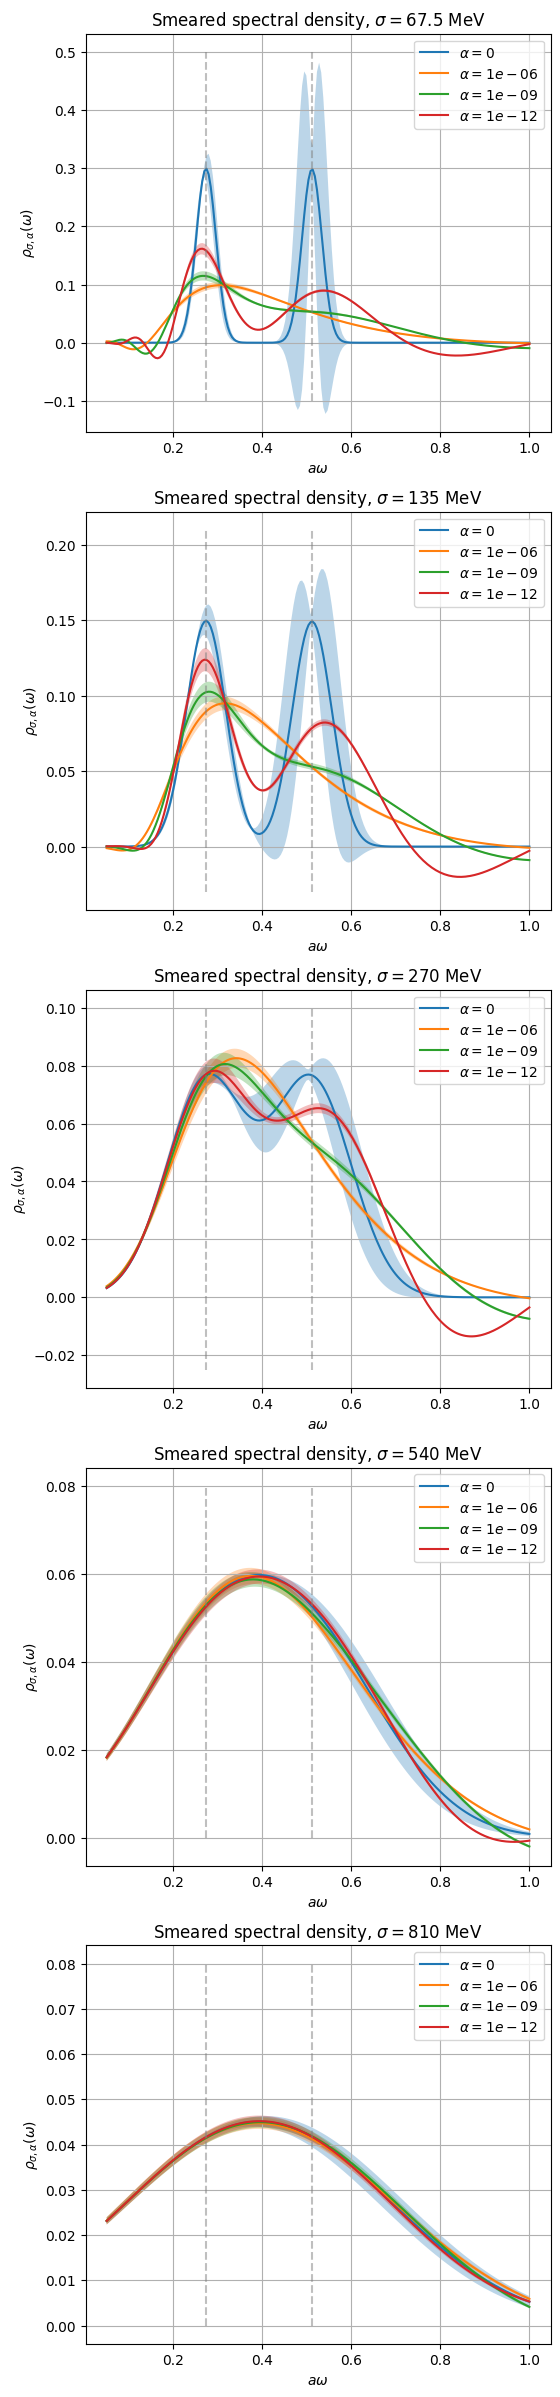

In [23]:
plt.figure(figsize=[6, 6*len(width)])
up_lim=[0.5, 0.210, 0.10, 0.08, 0.08]
lo_lim=[-0.1, -0.03, -0.025, 0.0, 0.0]
for i in range(len(width)):
    plt.subplot(len(width), 1, i+1)
    plt.title(r"Smeared spectral density, $\sigma = {}$ MeV".format(width[i]))
    for j in range(len(alpha_s)):
        plt.plot(x, sp_av[i, j, :], label = r"$\alpha = {}$".format(alpha_s[j]))
        plt.fill_between(x, sp_av[i, j, :] + sp_err[i, j, :], sp_av[i, j, :] - sp_err[i, j, :], alpha = 0.3)
    m1, m2 = np.zeros(10), np.zeros(10)
    for j in range(len(m1)):
        m1[j] = par[1]
        m2[j] = par[3]
    vert = np.linspace(lo_lim[i], up_lim[i], 10)
    plt.plot(m1, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
    plt.plot(m2, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
    plt.legend()
    plt.xlabel(r"$a\omega$")
    plt.ylabel(r"$\rho_{\sigma, \alpha}(\omega)$")
    plt.grid()
plt.savefig("Smeared_spectral_densities.png")

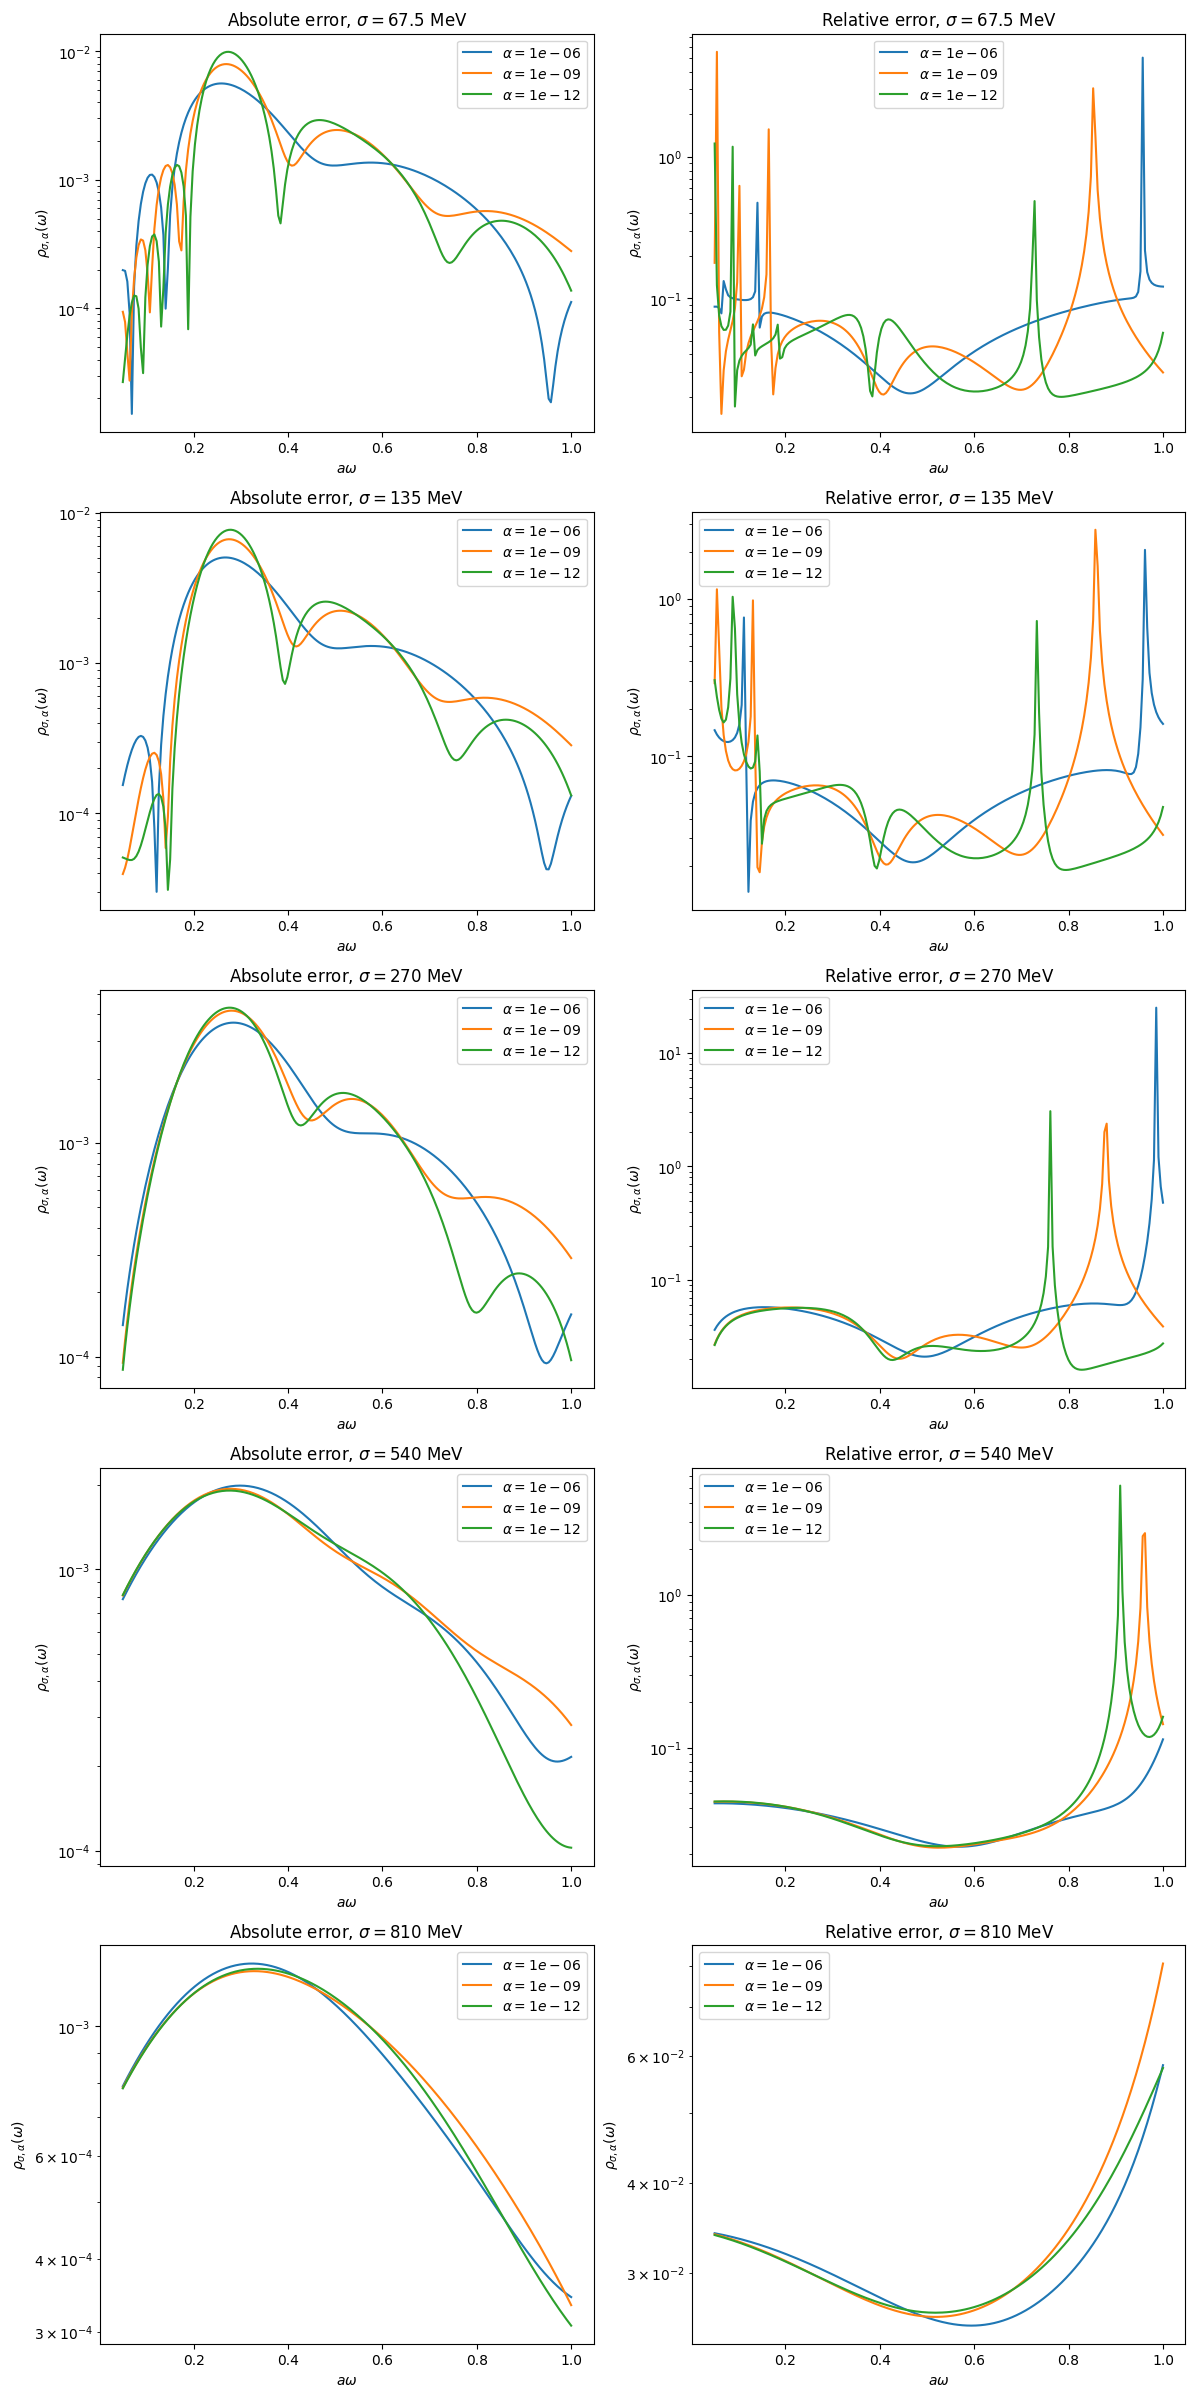

In [25]:
plt.figure(figsize=[14, 6*len(width)])
up_lim=[0.5, 0.210, 0.10, 0.08, 0.08]
lo_lim=[-0.1, -0.03, -0.025, 0.0, 0.0]
for i in range(len(width)):
    plt.subplot(len(width), 2, 2*i+1)
    plt.title(r"Absolute error, $\sigma = {}$ MeV".format(width[i]))
    for j in range(len(alpha_s)):
        if alpha_s[j] == 0:
            continue
        plt.plot(x, sp_err[i, j, :], label = r"$\alpha = {}$".format(alpha_s[j]))
    plt.semilogy()
    plt.legend()
    plt.xlabel(r"$a\omega$")
    plt.ylabel(r"$\rho_{\sigma, \alpha}(\omega)$")
    plt.subplot(len(width), 2, 2*(i+1))
    plt.title(r"Relative error, $\sigma = {}$ MeV".format(width[i]))
    for j in range(len(alpha_s)):
        if alpha_s[j] == 0:
            continue
        plt.plot(x, np.abs(sp_err[i, j, :]/sp_av[i, j, :]), label = r"$\alpha = {}$".format(alpha_s[j]))
    plt.semilogy()
    plt.legend()
    plt.xlabel(r"$a\omega$")
    plt.ylabel(r"$\rho_{\sigma, \alpha}(\omega)$")
plt.savefig("Error_plots.png")

## Integral with centre of kernel (probably wrong)

In [13]:
#MEAN VALUE AND ERROR WITH ALPHA != 0
def KI(s, w, sigma):
    return (sigma * gamma(0.25 + s * 0.5j) * complex(mpmath.hyp1f1(0.25 - s * 0.5j, 0.5, -w**2.0/(2*sigma**2.0))) +\
           np.sqrt(2) * w * gamma(0.75 + s * 0.5j) * complex(mpmath.hyp1f1(0.75 - s * 0.5j, 1.5, -w**2.0/(2*sigma**2.0)))) *\
           (2.0**(-1.75 + s * 0.5j)) * (sigma ** (-1.5 + s * 1.0j)) / np.pi

def kernel(w1, w2, a, s):
    f = lambda x: (2.0 * u_s(x, w1).conjugate() * H_a(x, a) * KI(x, w2, s)).real
    return quad(f, 0.0, +np.inf)[0]

def rho_k(w, par, a, s):
    return par[2] * kernel(w, par[3], a, s)/(par[3]**2.0) + par[0] * kernel(w, par[1], a, s)/(par[1]**2.0)

def KI_d(s, w, sigma):
    return ((-1.0 + s * 2.0j) * w * sigma * gamma(0.25 + s * 0.5j) * complex(mpmath.hyp1f1(0.25 + s * 0.5j, 1.5, w**2.0/(2*sigma**2.0))) + \
            2 * np.sqrt(2) * gamma(0.75 + s * 0.5j) * (sigma**2.0 * complex(mpmath.hyp1f1(0.75 + s * 0.5j, 0.5, w**2.0/(2*sigma**2.0))) - \
                                                       w**2.0 * complex(mpmath.hyp1f1(0.75 + s * 0.5j, 1.5, w**2.0/(2*sigma**2.0))))) *\
            2.0**(-2.75 + s * 0.5j) * np.exp(-w**2.0/(2*sigma**2.0)) * sigma**(-3.50 + s * 1.0j)

def kernel_d_m(w, m, a, s):
    f = lambda x: (2.0 * u_s(x, w).conjugate() * H_a(x, a) * KI_d(x, m, s)).real
    return quad(f, 0.0, +np.inf)[0]

def r_k_d_C0(w, par, a, s):
    return kernel(w, par[1], a, s)/par[1]**2.0

def r_k_d_C1(w, par, a, s):
    return kernel(w, par[3], a, s)/par[3]**2.0

def r_k_d_m0(w, par, a, s):
    return par[0] * (-2.0/(par[1]**3.0) * kernel(w, par[1], a, s) + kernel_d_m(w, par[1], a, s) /(par[1] ** 2.0))

def r_k_d_m1(w, par, a, s):
    return par[2] * (-2.0/(par[3]**3.0) * kernel(w, par[3], a, s) + kernel_d_m(w, par[3], a, s) /(par[3] ** 2.0))

def jac_r_k(w, par, a, s):
    return np.array([r_k_d_C0(w, par, a, s), r_k_d_m0(w, par, a, s), r_k_d_C1(w, par, a, s), r_k_d_m1(w, par, a, s)])

def err_r_k(w, par, a, s, cov):
    return np.sqrt(jac_r_k(w, par, a, s).T @ cov @ jac_r_k(w, par, a, s))

/tmp/ipykernel_29113/4114421329.py:5: RuntimeWarning: overflow encountered in cosh
  return np.pi/(np.pi + a*np.cosh(np.pi * s))
/tmp/ipykernel_29113/1223750958.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  return ((-1.0 + s * 2.0j) * w * sigma * gamma(0.25 + s * 0.5j) * complex(mpmath.hyp1f1(0.25 + s * 0.5j, 1.5, w**2.0/(2*sigma**2.0))) + \
/tmp/ipykernel_29113/1223750958.py:17: RuntimeWarning: invalid value encountered in multiply
  w**2.0 * complex(mpmath.hyp1f1(0.75 + s * 0.5j, 1.5, w**2.0/(2*sigma**2.0))))) *\
/tmp/ipykernel_29113/1223750958.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(f, 0.0, +np.inf)[0]


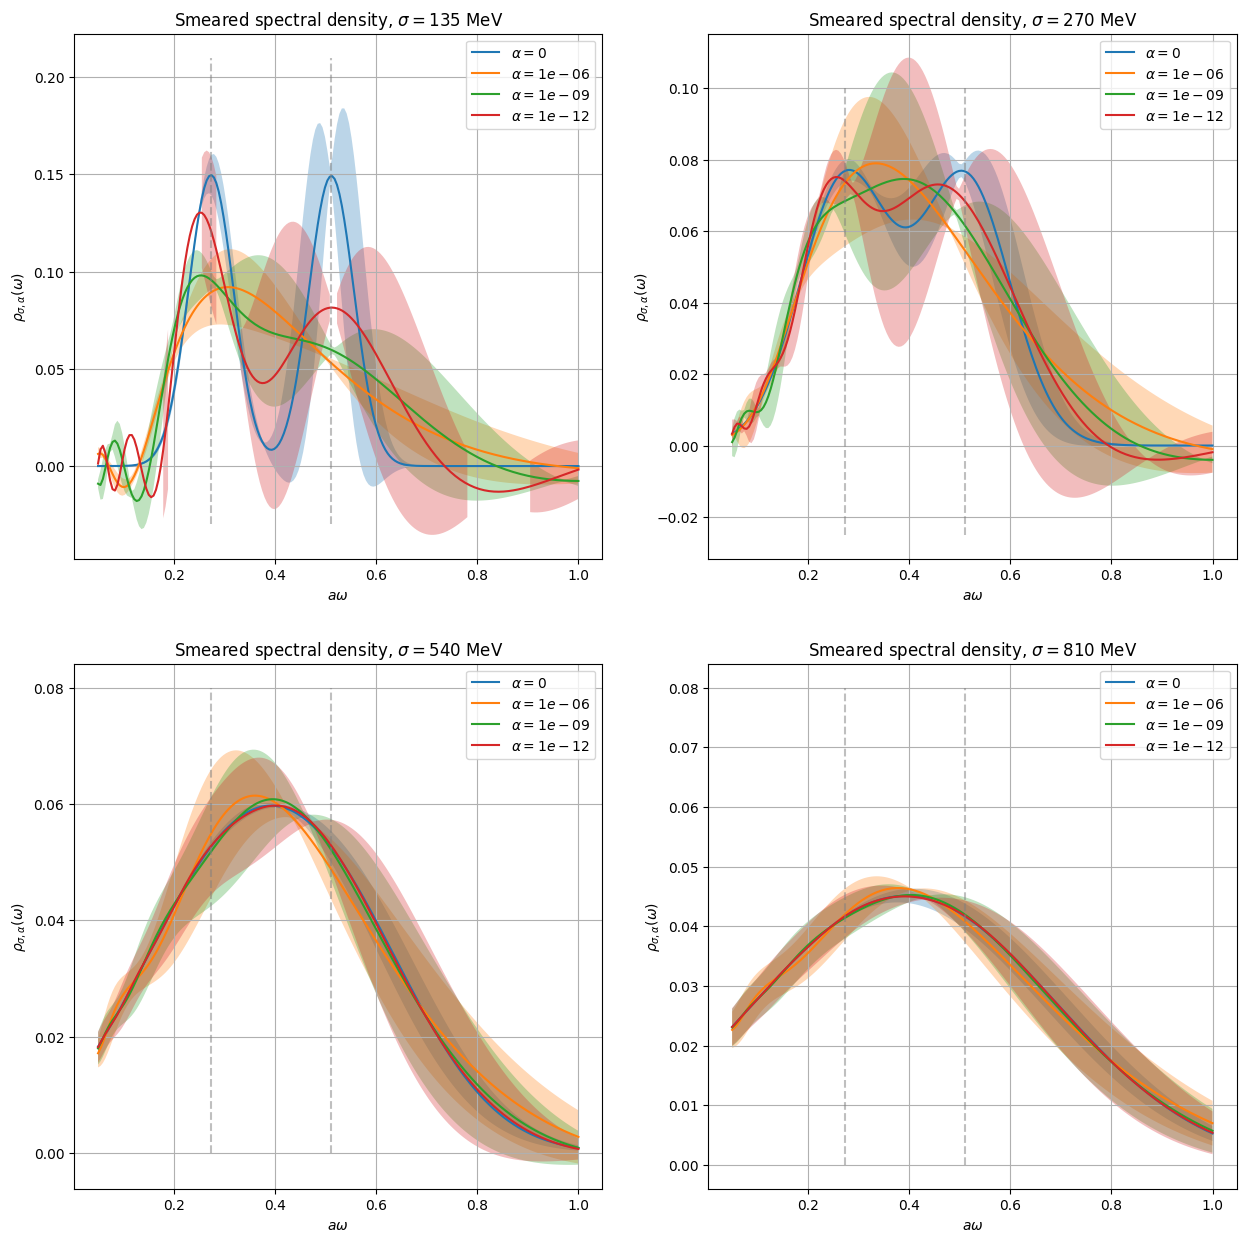

In [16]:
plt.figure(figsize=[15, 15])
x = np.linspace(0.05, 1, 200)
up_lim=[0.210, 0.10, 0.08, 0.08]
lo_lim=[-0.03, -0.025, 0.0, 0.0]
for i in range(len(width)):
    plt.subplot(2,2, i+1)
    s = width[i] * 0.065/197.3
    plt.title(r"Smeared spectral density, $\sigma = {}$ MeV".format(width[i]))
    for a in (alpha_s):
        if a == 0:
            y = []
            for k in x:
                y.append(err_rho(k, par, s, cov))
            plt.plot(x, rho(x, par, s), label = r"$\alpha = {}$".format(a))
            plt.fill_between(x, (rho(x, par, s)) + y, (rho(x, par, s)) - y, alpha = 0.3)
        else:
            y = []
            y_err = []
            for k in (x):
                y.append(rho_k(k, par, a, s))
                y_err.append(err_r_k(k, par, a, s, cov))
            plt.plot(x, y, label = r"$\alpha = {}$".format(a))
            plt.fill_between(x, np.array(y)+np.array(y_err), np.array(y)-np.array(y_err), alpha = 0.3)
    m1, m2 = np.zeros(10), np.zeros(10)
    for j in range(len(m1)):
        m1[j] = par[1]
        m2[j] = par[3]
    vert = np.linspace(lo_lim[i], up_lim[i], 10)
    plt.plot(m1, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
    plt.plot(m2, vert, linestyle = "dashed", color = "grey", alpha = 0.5)
    plt.legend()
    plt.xlabel(r"$a\omega$")
    plt.ylabel(r"$\rho_{\sigma, \alpha}(\omega)$")
    plt.grid()
plt.savefig("Smeared_spectral_densities.png")